In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-02-27 12:56:10.056325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(33)

In this experiment I'm going to show how to set the optimal bias initialization for your neural network. In particular, I'll use a subset of the cifat10 dataset, with unbalanced classes. Then, I'll train two network with this dataset, one with an optimized bias initialization and another one with a standard bias initialization.

The mathematical details can be found in my blog post (https://www.amolas.dev/blog/bias-initialization/)

# Load and prepare the data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
image_dim = x_train.shape[1:] 

In [5]:
x_train = x_train / 255.
x_test = x_test / 255.
y_train = y_train.ravel()
y_test = y_test.ravel()

# Take a sample of the dataset.

In [6]:
# for each class define how many examples do you want to get in the sampled dataset
samples = {0: 4000,
           1: 3700,
           2: 100,
           3: 4000,
           4: 400,
           5: 100,
           6: 50,
           7: 700,
           8: 700,
           9: 100}
total = sum(samples.values())

In [7]:
X_train = []
Y_train = []
acc = {i:0 for i in range(10)}
for image, label in zip(x_train, y_train):
    if acc[label] < samples[label]:
        X_train.append(image)
        Y_train.append(label)
        acc[label] += 1
X_train = np.array(X_train)
Y_train = tf.keras.utils.to_categorical(Y_train)

# Define the models

In [8]:
# Standard CNN approach.

def get_model(optimal_bias=True):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    if optimal_bias:
        initial_bias = tf.constant_initializer([np.log(samples[i]/total) for i in range(10)])
        output_layer = tf.keras.layers.Dense(units=10, 
                                             bias_initializer=initial_bias,
                                             activation='softmax')
    else:
        initial_bias = tf.constant_initializer([0 for i in range(10)])
        output_layer = tf.keras.layers.Dense(units=10, 
                                             bias_initializer=initial_bias, 
                                             activation='softmax')
    model.add(output_layer)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )
    return model

In [9]:
# Get the models
normal_model = get_model(optimal_bias=False)
opt_bias_model = get_model(optimal_bias=True)

2023-02-27 12:56:16.456415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Run some checks

In [10]:
# expected loss from using a non-informative initialization
exp = -sum([n_i/total * np.log(1/10) for n_i in samples.values()])

# actual loss
pretrain_preds = normal_model.predict(X_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

Non-optimized model
    Expected pre-training loss 2.3025850929940463
    Actual pre-training loss 2.271348714828491


In [11]:
# expected loss from using an optimal initialization
exp = -sum([n_i/total * np.log(n_i/total) for n_i in samples.values()])

# actual loss
pretrain_preds = opt_bias_model.predict(X_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

Non-optimized model
    Expected pre-training loss 1.6012265347398464
    Actual pre-training loss 1.5987855195999146


# Train model

In [12]:
# Define this callback to have access to training loss at every batch

class BatchLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))


In [13]:
epochs = 1
batch_size = 256

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(X_train, 
                                  Y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(X_train, 
                                      Y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

55/55 [==============================] - 5s 87ms/step - loss: 1.4604 - accuracy: 0.4716


# Show the results

In the plot below we see that the optimized model converges faster and the initial loss is lower that the non-optimal model.

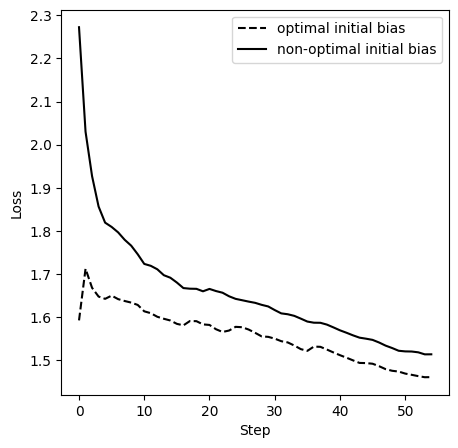

In [14]:
plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, 'k--', label="optimal initial bias")
plt.plot(normal_callback.batch_losses, 'k-', label="non-optimal initial bias")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.savefig("opt-vs-normal-loss.svg", bbox_inches = "tight", transparent=True)